In [145]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
import gc
import os
import matplotlib.pyplot as plt
import seaborn as sns 
import lightgbm as lgb
import itertools
import pickle, gzip
import glob
import importlib
import time

from cv_sampler import *

np.warnings.filterwarnings('ignore')


In [135]:
import load_data
importlib.reload(load_data)

<module 'load_data' from '/home/matsui-k/projects/kaggle-lsst/scripts/load_data.py'>

In [136]:
a = load_data.load_train()

In [159]:
del a

In [3]:
train_df = pd.read_csv('../input/training_set.csv')
feature_df = load_data.featurize(train_df)

In [4]:
period_df = load_data.load_train_period()
concat_df = pd.concat([feature_df, period_df], axis=1)

In [6]:
concat_df.head()

flux_min    flux_max   flux_mean  flux_median    flux_std  \
object_id                                                                 
615       -1100.440063  660.626343 -123.096998   -89.477524  394.109851   
713         -14.735178   14.770886   -1.423351    -0.873033    6.471144   
730         -19.159811   47.310059    2.267434     0.409172    8.022239   
745         -15.494463  220.795212    8.909206     1.035895   27.558208   
1124        -16.543753  143.600189    7.145702     1.141288   20.051722   

           flux_skew  flux_err_min  flux_err_std  detected_mean  \
object_id                                                         
615        -0.349540      2.130510      1.744747       0.946023   
713         0.014989      0.639458      1.509888       0.171429   
730         3.177854      0.695106      1.721134       0.069697   
745         4.979826      0.567170      3.537324       0.173789   
1124        4.406298      0.695277      1.933837       0.173295   

           flux_kurtosis    ...     flux_max_dbmed_4  flux_max_dbmed_5  \
object_id                   ...                                          
615            -0.259823    ...             1.253581          1.347203   
713            -1.033674    ...             1.795795          2.619576   
730            12.721113    ...            16.628844          9.372257   
745            28.743551    ...            80.487077         23.779494   
1124           22.144185    ...            61.234234         20.666712   

           flux_min_dbmed_0  flux_min_dbmed_1  flux_min_dbmed_2  \
object_id                                                         
615               -1.347288         -1.696237         -1.467772   
713               -2.342578         -2.598820         -2.020706   
730               -2.814196         -3.349020         -2.802594   
745               -2.158167         -3.049072         -1.629623   
1124              -4.458969         -1.707107         -1.821437   

           flux_min_dbmed_3  flux_min_dbmed_4  flux_min_dbmed_5  best_period  \
object_id                                                                      
615               -1.529332         -1.385619         -1.506175     0.324499   
713               -2.290730         -2.245088         -2.520311     0.996583   
730               -2.905436         -2.357899         -3.795613     0.999506   
745               -2.462276         -6.791281         -1.722278     0.998658   
1124              -1.617562         -7.054615         -2.056217     0.994986   

              score  
object_id            
615        0.953991  
713        0.811500  
730        0.520470  
745        0.317712  
1124       0.428142  

[5 rows x 89 columns]

In [5]:
meta_data = pd.read_csv('../input/training_set_metadata.csv')

In [8]:
gal_cut = meta_data.hostgal_specz == 0

In [11]:
gal_cut.index = meta_data.object_id

In [38]:
gal_df = concat_df[gal_cut]

In [16]:
ex_df = concat_df[~gal_cut]

In [18]:
meta_data.index = meta_data.object_id

In [70]:
gal_target, ex_target = load_data.cut_galaxy(meta_data.target, meta_data)

In [72]:
gal_classes = sorted(gal_target.unique())
gal_classes

[6, 16, 53, 65, 92]

In [73]:
gal_class_weight = {
    i: (2 if c in [15, 64] else 1)  for i, c in enumerate(gal_classes)
}

In [74]:
gal_class_weight

{0: 1, 1: 1, 2: 1, 3: 1, 4: 1}

In [75]:
gal_w = gal_target.value_counts()
gal_w

65    981
16    924
92    239
6     151
53     30
Name: target, dtype: int64

In [76]:
gal_sample_weights = {i : np.sum(gal_w) / gal_w[c] for i, c in enumerate(gal_classes)}
gal_sample_weights

{0: 15.397350993377483,
 1: 2.5162337662337664,
 2: 77.5,
 3: 2.3700305810397553,
 4: 9.728033472803347}

In [77]:
gal_target_i = gal_target.apply(lambda x: gal_classes.index(x))

In [148]:
param_samplers = {
    'learning_rate': LogUniformSampler(-2, -1),
    'subsample': UniformSampler(0.7, 1),
    'colsample_bytree': UniformSampler(0.3, 1),
    'reg_alpha': LogUniformSampler(-3, -1),
    'reg_lambda': LogUniformSampler(-3, -1),
    'min_split_gain': LogUniformSampler(-3, -1),
    'min_child_weight': LogUniformSampler(1, 2),
    'n_estimators': UniformSampler(300, 5000, int),
    'max_depth': UniformSampler(3, 10, int)
}
 
folds = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)
param_list = []
score_list = []
n_seed = 100
for i_seed in range(n_seed):
    print(i_seed, time.ctime())
    gal_clfs = []
    gal_importances = pd.DataFrame()
    gal_lgb_params = {
        'boosting_type': 'gbdt',
        'objective': 'multiclass',
        'num_class': 5,
        'metric': 'multi_logloss',
        'class_weight': gal_class_weight,
        'learning_rate': param_samplers['learning_rate'].rvs(),
        'subsample': param_samplers['subsample'].rvs(),
        'colsample_bytree': param_samplers['colsample_bytree'].rvs(),
        'reg_alpha': param_samplers['reg_alpha'].rvs(),
        'reg_lambda': param_samplers['reg_lambda'].rvs(),
        'min_split_gain': param_samplers['min_split_gain'].rvs(),
        'min_child_weight': param_samplers['min_child_weight'].rvs(),
        'n_estimators': param_samplers['n_estimators'].rvs(),
        'max_depth': param_samplers['max_depth'].rvs(),
        'silent': True
    }
    
    param_list.append(gal_lgb_params)
    
    seed_score_list = []
    for i_fold, (trn_index, val_index) in enumerate(folds.split(gal_target_i, gal_target_i)):
        trn_x, trn_y = gal_df.iloc[trn_index], gal_target_i.iloc[trn_index]
        val_x, val_y = gal_df.iloc[val_index], gal_target_i.iloc[val_index]

        gal_clf = lgb.LGBMClassifier(**gal_lgb_params)
        gal_clf.fit(
            trn_x, trn_y,
            sample_weight=trn_y.map(gal_sample_weights),
            eval_set=[(val_x, val_y)],
            eval_metric='multi_logloss',
            eval_class_weight=[gal_class_weight],
            verbose=False,
            early_stopping_rounds=50
        )

        imp_df = pd.DataFrame()
        imp_df['feature'] = gal_df.columns
        imp_df['gain'] = gal_clf.feature_importances_
        imp_df['fold'] = i_fold + 1
        gal_importances = pd.concat([gal_importances, imp_df], axis=0, sort=False)

        gal_clfs.append(gal_clf)
        
        seed_score_list.append(gal_clf.best_score_['valid_0']['multi_logloss'])
    score_list.append(np.mean(seed_score_list))


param_keys = ['learning_rate',
  'subsample',
  'colsample_bytree',
  'reg_alpha',
  'reg_lambda',
  'min_split_gain',
  'min_child_weight',
  'n_estimators',
  'max_depth']

for param_key in param_keys:
    values = [ param_dict[param_key] for param_dict in param_list]
    plt.figure(figsize=(5, 5))
    plt.title(param_key)
    plt.plot(values, score_list, 'o')
    plt.figure(figsize=(5, 5))
    plt.title(param_key+'_log')
    plt.plot(values, score_list, 'o')
    plt.xscale('log')

0 Fri Dec  7 22:31:08 2018
1 Fri Dec  7 22:31:11 2018
2 Fri Dec  7 22:31:13 2018
3 Fri Dec  7 22:31:15 2018
4 Fri Dec  7 22:31:19 2018
5 Fri Dec  7 22:31:23 2018
6 Fri Dec  7 22:31:24 2018
7 Fri Dec  7 22:31:27 2018
8 Fri Dec  7 22:31:33 2018
9 Fri Dec  7 22:31:39 2018
10 Fri Dec  7 22:31:41 2018
11 Fri Dec  7 22:31:42 2018
12 Fri Dec  7 22:31:45 2018
13 Fri Dec  7 22:31:47 2018
14 Fri Dec  7 22:31:49 2018
15 Fri Dec  7 22:31:53 2018
16 Fri Dec  7 22:31:54 2018
17 Fri Dec  7 22:31:57 2018
18 Fri Dec  7 22:32:03 2018
19 Fri Dec  7 22:32:05 2018
20 Fri Dec  7 22:32:07 2018
21 Fri Dec  7 22:32:13 2018
22 Fri Dec  7 22:32:15 2018
23 Fri Dec  7 22:32:18 2018
24 Fri Dec  7 22:32:21 2018
25 Fri Dec  7 22:32:23 2018
26 Fri Dec  7 22:32:26 2018
27 Fri Dec  7 22:32:30 2018
28 Fri Dec  7 22:32:35 2018
29 Fri Dec  7 22:32:38 2018
30 Fri Dec  7 22:32:40 2018
31 Fri Dec  7 22:32:45 2018
32 Fri Dec  7 22:32:49 2018
33 Fri Dec  7 22:32:51 2018
34 Fri Dec  7 22:32:54 2018
35 Fri Dec  7 22:32:55 2018
36

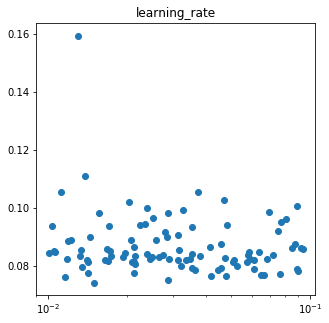

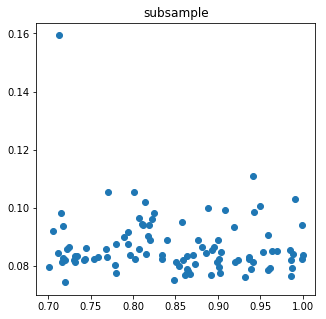

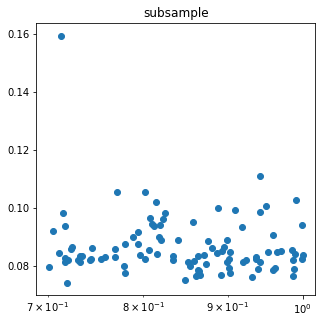

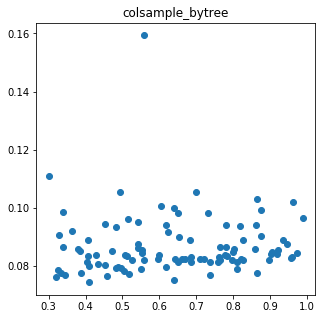

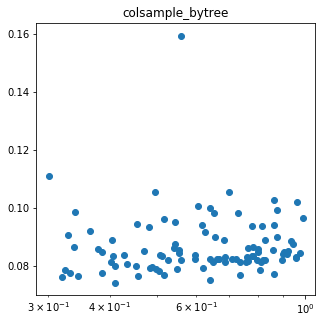

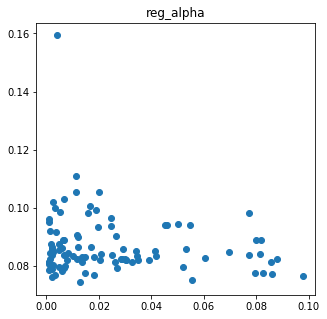

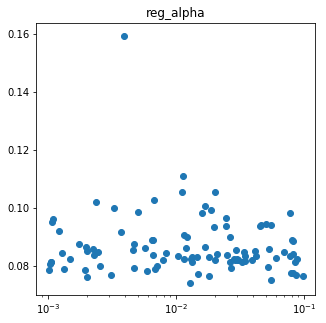

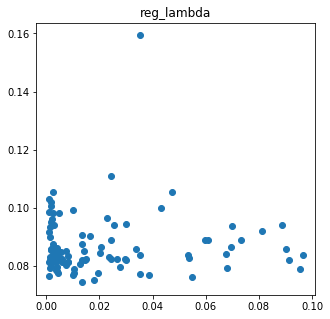

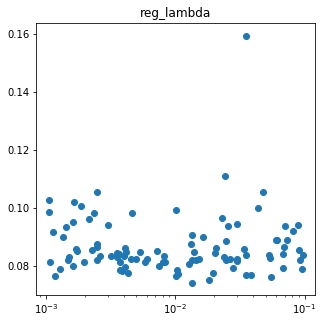

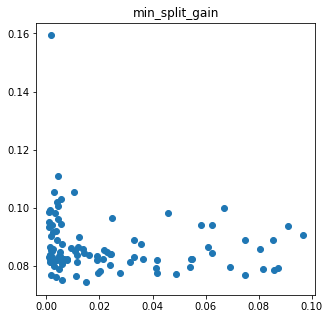

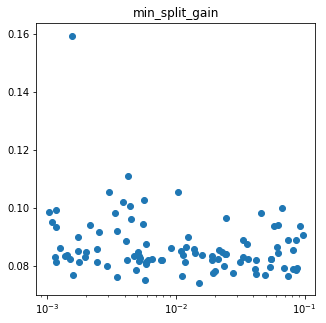

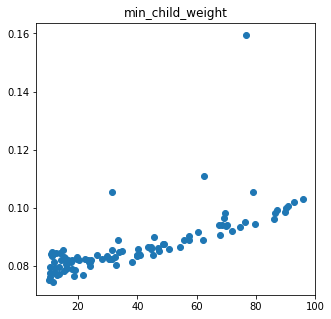

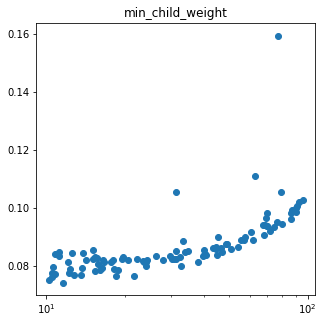

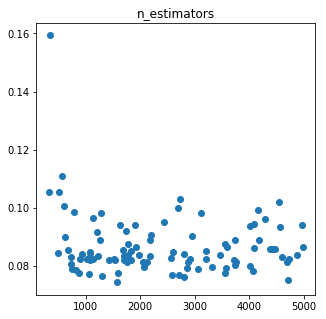

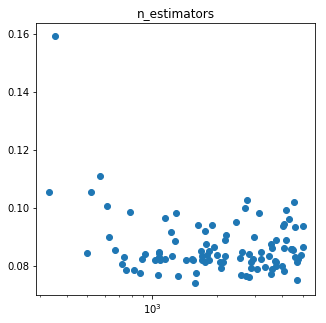

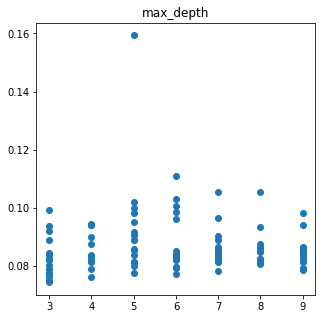

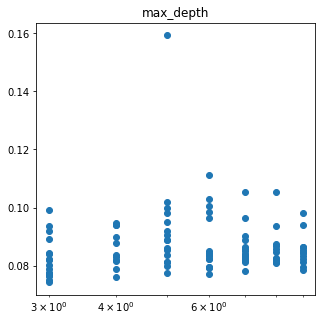

In [154]:
for param_key in param_keys:
    values = [ param_dict[param_key] for param_dict in param_list]
    plt.figure(figsize=(5, 5))
    plt.title(param_key)
    plt.plot(values, score_list, 'o')
    plt.figure(figsize=(5, 5))
    plt.title(param_key)
    plt.plot(values, score_list, 'o')
    plt.xscale('log')

In [139]:

barplot_imp = pd.DataFrame()
barplot_imp.index = gal_importances.groupby('feature').gain.mean().index
barplot_imp['gain'] = gal_importances.groupby('feature').gain.mean()
barplot_imp

ValueError: Length mismatch: Expected axis has 0 elements, new values have 89 elements

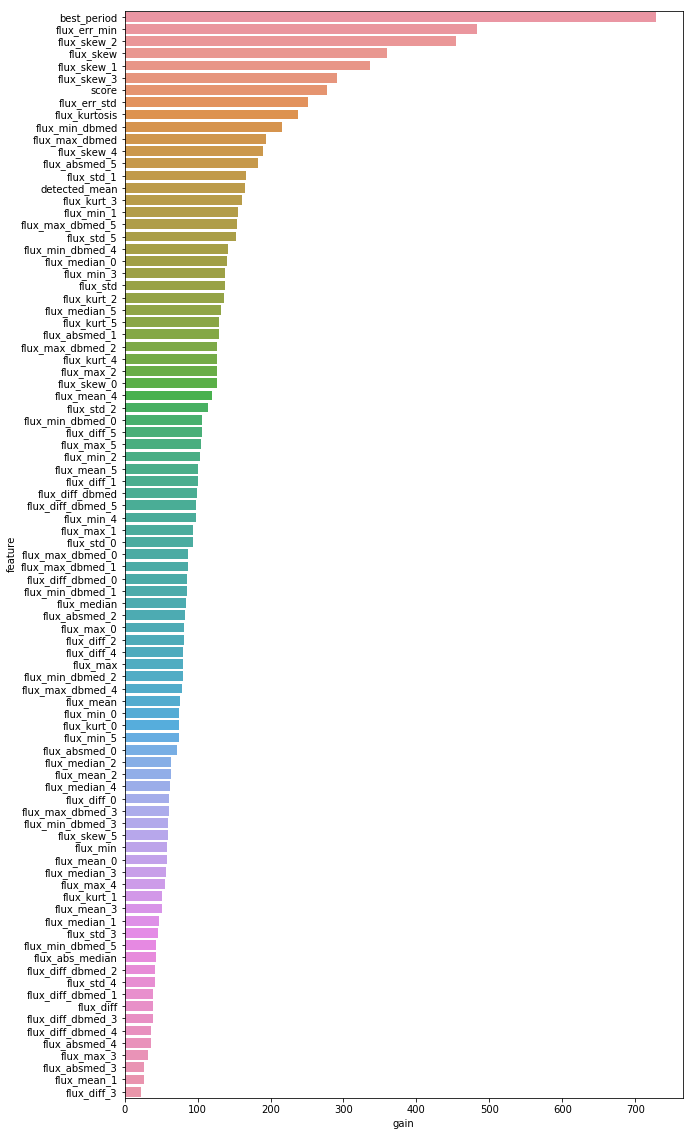

In [134]:
plt.figure(figsize=(10, 20))
sns.barplot(y='feature', x='gain', data=barplot_imp.sort_values('gain', ascending=False))

In [138]:
gal_importances.groupby('feature').gain.mean()

feature
best_period          728.666667
detected_mean        164.666667
flux_abs_median       43.333333
flux_absmed_0         71.333333
flux_absmed_1        128.666667
flux_absmed_2         83.333333
flux_absmed_3         27.000000
flux_absmed_4         36.000000
flux_absmed_5        182.333333
flux_diff             38.333333
flux_diff_0           61.000000
flux_diff_1          100.666667
flux_diff_2           81.000000
flux_diff_3           22.000000
flux_diff_4           80.333333
flux_diff_5          105.666667
flux_diff_dbmed       99.000000
flux_diff_dbmed_0     86.000000
flux_diff_dbmed_1     39.333333
flux_diff_dbmed_2     41.666667
flux_diff_dbmed_3     38.333333
flux_diff_dbmed_4     36.666667
flux_diff_dbmed_5     98.333333
flux_err_min         483.000000
flux_err_std         250.666667
flux_kurt_0           75.000000
flux_kurt_1           51.000000
flux_kurt_2          136.000000
flux_kurt_3          160.666667
flux_kurt_4          126.666667
                        ...    


0 Fri Dec  7 22:53:47 2018
1 Fri Dec  7 22:53:49 2018
2 Fri Dec  7 22:53:53 2018
3 Fri Dec  7 22:53:55 2018
4 Fri Dec  7 22:53:56 2018
5 Fri Dec  7 22:53:57 2018
6 Fri Dec  7 22:53:59 2018
7 Fri Dec  7 22:54:01 2018
8 Fri Dec  7 22:54:03 2018
9 Fri Dec  7 22:54:04 2018
10 Fri Dec  7 22:54:06 2018
11 Fri Dec  7 22:54:06 2018
12 Fri Dec  7 22:54:08 2018
13 Fri Dec  7 22:54:09 2018
14 Fri Dec  7 22:54:11 2018
15 Fri Dec  7 22:54:12 2018
16 Fri Dec  7 22:54:15 2018
17 Fri Dec  7 22:54:16 2018
18 Fri Dec  7 22:54:17 2018
19 Fri Dec  7 22:54:18 2018
20 Fri Dec  7 22:54:19 2018
21 Fri Dec  7 22:54:20 2018
22 Fri Dec  7 22:54:22 2018
23 Fri Dec  7 22:54:23 2018
24 Fri Dec  7 22:54:25 2018
25 Fri Dec  7 22:54:27 2018
26 Fri Dec  7 22:54:30 2018
27 Fri Dec  7 22:54:31 2018
28 Fri Dec  7 22:54:32 2018
29 Fri Dec  7 22:54:34 2018
30 Fri Dec  7 22:54:35 2018
31 Fri Dec  7 22:54:37 2018
32 Fri Dec  7 22:54:41 2018
33 Fri Dec  7 22:54:42 2018
34 Fri Dec  7 22:54:43 2018
35 Fri Dec  7 22:54:46 2018
36

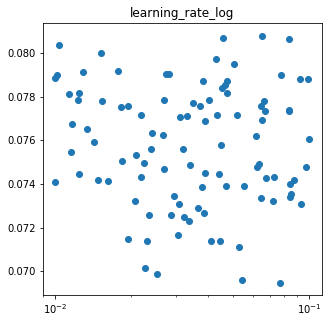

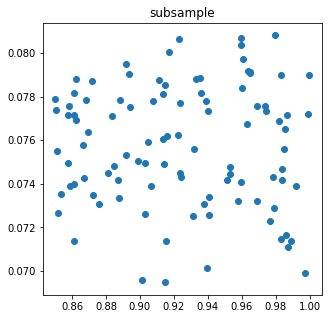

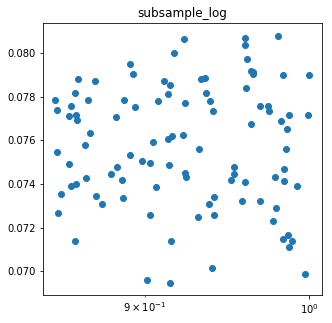

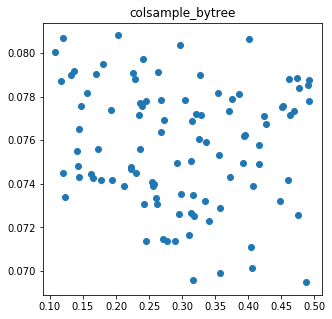

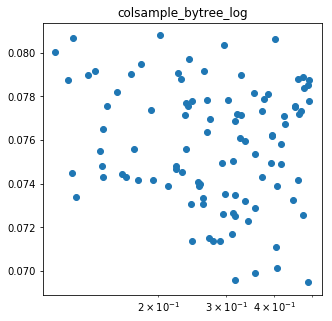

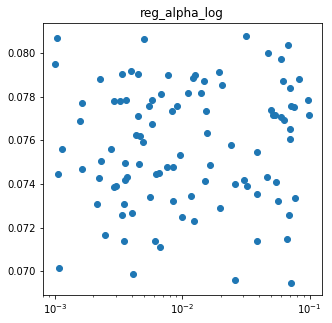

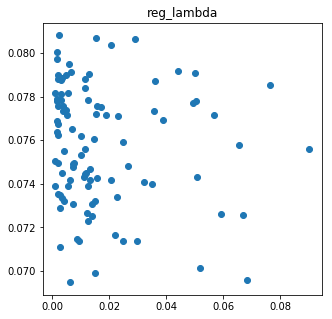

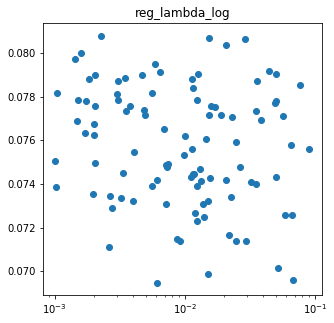

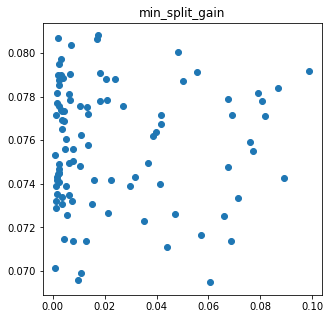

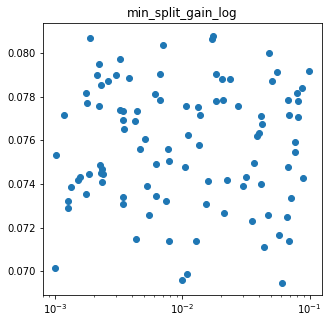

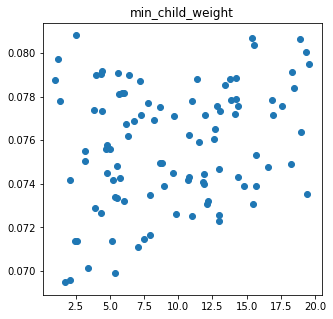

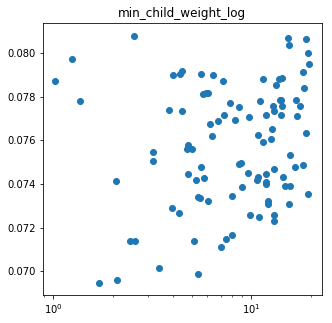

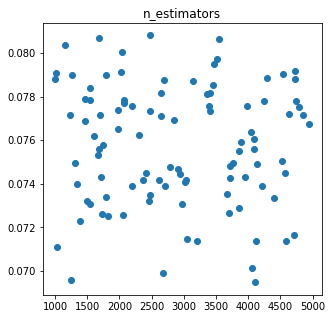

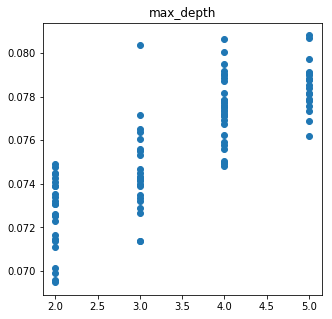

In [155]:
param_samplers = {
    'learning_rate': LogUniformSampler(-2, -1),
    'subsample': UniformSampler(0.85, 1),
    'colsample_bytree': UniformSampler(0.1, 0.5),
    'reg_alpha': LogUniformSampler(-3, -1),
    'reg_lambda': LogUniformSampler(-3, -1),
    'min_split_gain': LogUniformSampler(-3, -1),
    'min_child_weight': UniformSampler(1, 20),
    'n_estimators': UniformSampler(1000, 5000, int),
    'max_depth': UniformSampler(2, 6, int)
}
 
folds = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)
param_list = []
score_list = []
n_seed = 100
for i_seed in range(n_seed):
    print(i_seed, time.ctime())
    gal_clfs = []
    gal_importances = pd.DataFrame()
    gal_lgb_params = {
        'boosting_type': 'gbdt',
        'objective': 'multiclass',
        'num_class': 5,
        'metric': 'multi_logloss',
        'class_weight': gal_class_weight,
        'learning_rate': param_samplers['learning_rate'].rvs(),
        'subsample': param_samplers['subsample'].rvs(),
        'colsample_bytree': param_samplers['colsample_bytree'].rvs(),
        'reg_alpha': param_samplers['reg_alpha'].rvs(),
        'reg_lambda': param_samplers['reg_lambda'].rvs(),
        'min_split_gain': param_samplers['min_split_gain'].rvs(),
        'min_child_weight': param_samplers['min_child_weight'].rvs(),
        'n_estimators': param_samplers['n_estimators'].rvs(),
        'max_depth': param_samplers['max_depth'].rvs(),
        'silent': True,
        'n_jobs': 6
    }
    
    param_list.append(gal_lgb_params)
    
    seed_score_list = []
    for i_fold, (trn_index, val_index) in enumerate(folds.split(gal_target_i, gal_target_i)):
        trn_x, trn_y = gal_df.iloc[trn_index], gal_target_i.iloc[trn_index]
        val_x, val_y = gal_df.iloc[val_index], gal_target_i.iloc[val_index]

        gal_clf = lgb.LGBMClassifier(**gal_lgb_params)
        gal_clf.fit(
            trn_x, trn_y,
            sample_weight=trn_y.map(gal_sample_weights),
            eval_set=[(val_x, val_y)],
            eval_metric='multi_logloss',
            eval_class_weight=[gal_class_weight],
            verbose=False,
            early_stopping_rounds=50
        )

        imp_df = pd.DataFrame()
        imp_df['feature'] = gal_df.columns
        imp_df['gain'] = gal_clf.feature_importances_
        imp_df['fold'] = i_fold + 1
        gal_importances = pd.concat([gal_importances, imp_df], axis=0, sort=False)

        gal_clfs.append(gal_clf)
        
        seed_score_list.append(gal_clf.best_score_['valid_0']['multi_logloss'])
    score_list.append(np.mean(seed_score_list))


param_keys = ['learning_rate',
  'subsample',
  'colsample_bytree',
  'reg_alpha',
  'reg_lambda',
  'min_split_gain',
  'min_child_weight',
  'n_estimators',
  'max_depth']

for param_key in param_keys:
    values = [ param_dict[param_key] for param_dict in param_list]
    plt.figure(figsize=(5, 5))
    plt.title(param_key)
    plt.plot(values, score_list, 'o')
    plt.figure(figsize=(5, 5))
    plt.title(param_key+'_log')
    plt.plot(values, score_list, 'o')
    plt.xscale('log')

0 Fri Dec  7 23:05:24 2018
1 Fri Dec  7 23:05:27 2018
2 Fri Dec  7 23:05:30 2018
3 Fri Dec  7 23:05:31 2018
4 Fri Dec  7 23:05:33 2018
5 Fri Dec  7 23:05:36 2018
6 Fri Dec  7 23:05:37 2018
7 Fri Dec  7 23:05:38 2018
8 Fri Dec  7 23:05:40 2018
9 Fri Dec  7 23:05:42 2018
10 Fri Dec  7 23:05:44 2018
11 Fri Dec  7 23:05:45 2018
12 Fri Dec  7 23:05:47 2018
13 Fri Dec  7 23:05:49 2018
14 Fri Dec  7 23:05:51 2018
15 Fri Dec  7 23:05:55 2018
16 Fri Dec  7 23:05:57 2018
17 Fri Dec  7 23:05:59 2018
18 Fri Dec  7 23:06:02 2018
19 Fri Dec  7 23:06:04 2018
20 Fri Dec  7 23:06:06 2018
21 Fri Dec  7 23:06:09 2018
22 Fri Dec  7 23:06:11 2018
23 Fri Dec  7 23:06:12 2018
24 Fri Dec  7 23:06:14 2018
25 Fri Dec  7 23:06:16 2018
26 Fri Dec  7 23:06:18 2018
27 Fri Dec  7 23:06:21 2018
28 Fri Dec  7 23:06:22 2018
29 Fri Dec  7 23:06:24 2018
30 Fri Dec  7 23:06:27 2018
31 Fri Dec  7 23:06:30 2018
32 Fri Dec  7 23:06:32 2018
33 Fri Dec  7 23:06:34 2018
34 Fri Dec  7 23:06:35 2018
35 Fri Dec  7 23:06:37 2018
36

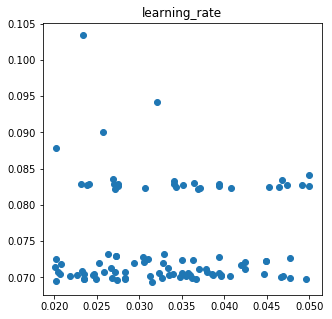

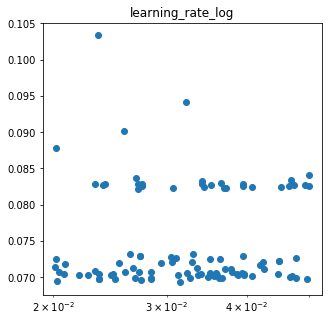

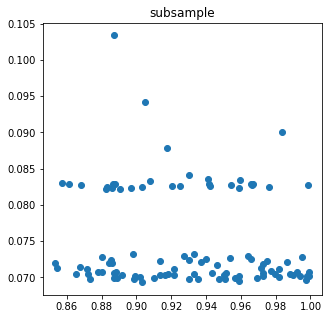

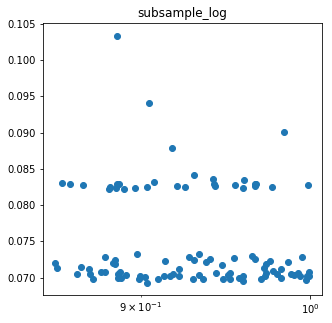

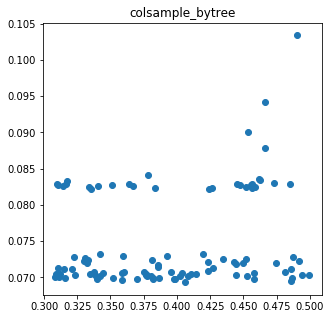

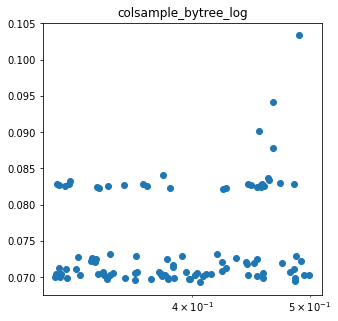

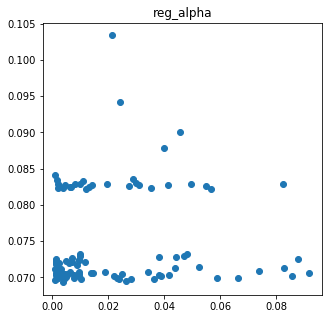

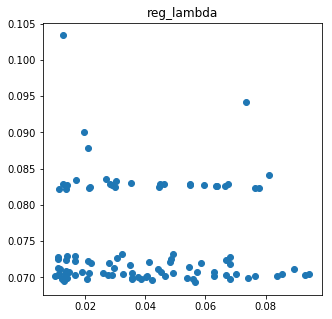

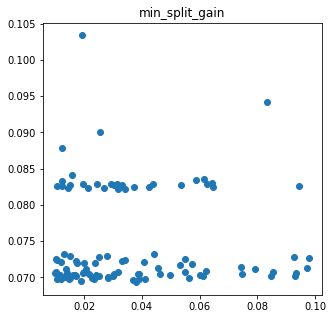

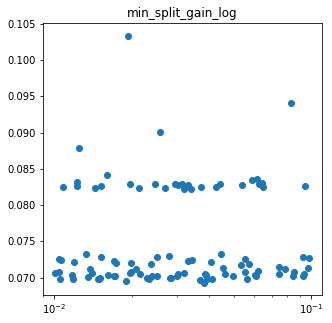

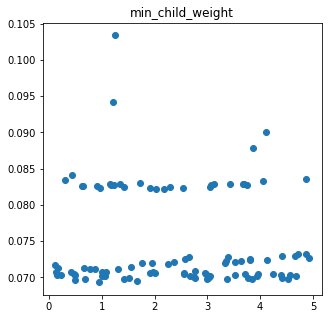

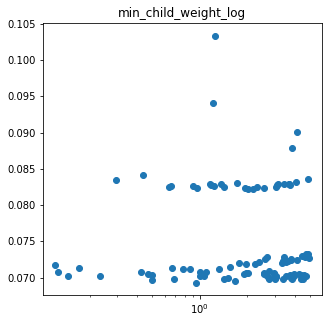

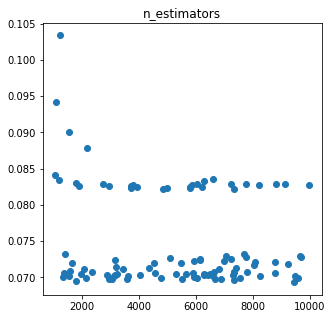

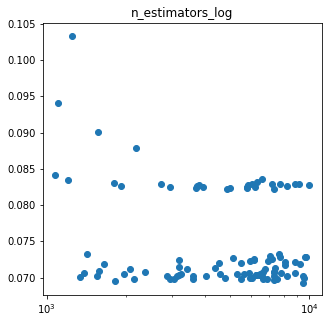

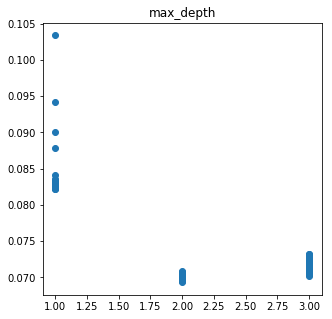

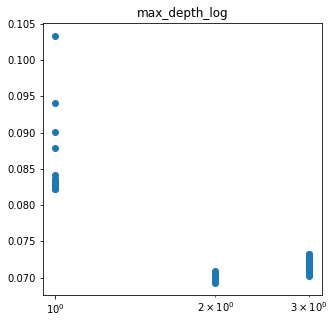

In [156]:
param_samplers = {
    'learning_rate': UniformSampler(0.02, 0.05),
    'subsample': UniformSampler(0.85, 1),
    'colsample_bytree': UniformSampler(0.3, 0.5),
    'reg_alpha': LogUniformSampler(-3, -1),
    'reg_lambda': LogUniformSampler(-2, -1),
    'min_split_gain': LogUniformSampler(-2, -1),
    'min_child_weight': UniformSampler(0.1, 5),
    'n_estimators': UniformSampler(1000, 10000, int),
    'max_depth': UniformSampler(1, 4, int)
}
 
folds = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)
param_list = []
score_list = []
n_seed = 100
for i_seed in range(n_seed):
    print(i_seed, time.ctime())
    gal_clfs = []
    gal_importances = pd.DataFrame()
    gal_lgb_params = {
        'boosting_type': 'gbdt',
        'objective': 'multiclass',
        'num_class': 5,
        'metric': 'multi_logloss',
        'class_weight': gal_class_weight,
        'learning_rate': param_samplers['learning_rate'].rvs(),
        'subsample': param_samplers['subsample'].rvs(),
        'colsample_bytree': param_samplers['colsample_bytree'].rvs(),
        'reg_alpha': param_samplers['reg_alpha'].rvs(),
        'reg_lambda': param_samplers['reg_lambda'].rvs(),
        'min_split_gain': param_samplers['min_split_gain'].rvs(),
        'min_child_weight': param_samplers['min_child_weight'].rvs(),
        'n_estimators': param_samplers['n_estimators'].rvs(),
        'max_depth': param_samplers['max_depth'].rvs(),
        'silent': True,
        'n_jobs': 6
    }
    
    param_list.append(gal_lgb_params)
    
    seed_score_list = []
    for i_fold, (trn_index, val_index) in enumerate(folds.split(gal_target_i, gal_target_i)):
        trn_x, trn_y = gal_df.iloc[trn_index], gal_target_i.iloc[trn_index]
        val_x, val_y = gal_df.iloc[val_index], gal_target_i.iloc[val_index]

        gal_clf = lgb.LGBMClassifier(**gal_lgb_params)
        gal_clf.fit(
            trn_x, trn_y,
            sample_weight=trn_y.map(gal_sample_weights),
            eval_set=[(val_x, val_y)],
            eval_metric='multi_logloss',
            eval_class_weight=[gal_class_weight],
            verbose=False,
            early_stopping_rounds=50
        )

        imp_df = pd.DataFrame()
        imp_df['feature'] = gal_df.columns
        imp_df['gain'] = gal_clf.feature_importances_
        imp_df['fold'] = i_fold + 1
        gal_importances = pd.concat([gal_importances, imp_df], axis=0, sort=False)

        gal_clfs.append(gal_clf)
        
        seed_score_list.append(gal_clf.best_score_['valid_0']['multi_logloss'])
    score_list.append(np.mean(seed_score_list))


param_keys = ['learning_rate',
  'subsample',
  'colsample_bytree',
  'reg_alpha',
  'reg_lambda',
  'min_split_gain',
  'min_child_weight',
  'n_estimators',
  'max_depth']

for param_key in param_keys:
    values = [ param_dict[param_key] for param_dict in param_list]
    plt.figure(figsize=(5, 5))
    plt.title(param_key)
    plt.plot(values, score_list, 'o')
    plt.figure(figsize=(5, 5))
    plt.title(param_key+'_log')
    plt.plot(values, score_list, 'o')
    plt.xscale('log')

0 Fri Dec  7 23:13:10 2018
1 Fri Dec  7 23:13:14 2018
2 Fri Dec  7 23:13:16 2018
3 Fri Dec  7 23:13:17 2018
4 Fri Dec  7 23:13:18 2018
5 Fri Dec  7 23:13:20 2018
6 Fri Dec  7 23:13:21 2018
7 Fri Dec  7 23:13:23 2018
8 Fri Dec  7 23:13:24 2018
9 Fri Dec  7 23:13:26 2018
10 Fri Dec  7 23:13:26 2018
11 Fri Dec  7 23:13:30 2018
12 Fri Dec  7 23:13:31 2018
13 Fri Dec  7 23:13:33 2018
14 Fri Dec  7 23:13:35 2018
15 Fri Dec  7 23:13:35 2018
16 Fri Dec  7 23:13:38 2018
17 Fri Dec  7 23:13:40 2018
18 Fri Dec  7 23:13:42 2018
19 Fri Dec  7 23:13:44 2018
20 Fri Dec  7 23:13:47 2018
21 Fri Dec  7 23:13:49 2018
22 Fri Dec  7 23:13:51 2018
23 Fri Dec  7 23:13:55 2018
24 Fri Dec  7 23:13:56 2018
25 Fri Dec  7 23:14:00 2018
26 Fri Dec  7 23:14:02 2018
27 Fri Dec  7 23:14:04 2018
28 Fri Dec  7 23:14:06 2018
29 Fri Dec  7 23:14:08 2018
30 Fri Dec  7 23:14:09 2018
31 Fri Dec  7 23:14:09 2018
32 Fri Dec  7 23:14:12 2018
33 Fri Dec  7 23:14:16 2018
34 Fri Dec  7 23:14:18 2018
35 Fri Dec  7 23:14:19 2018
36

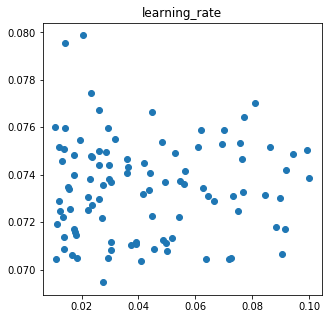

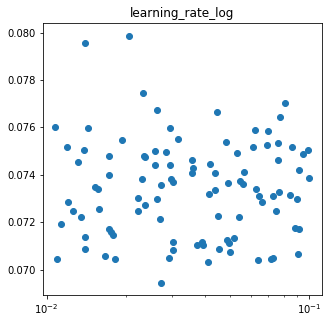

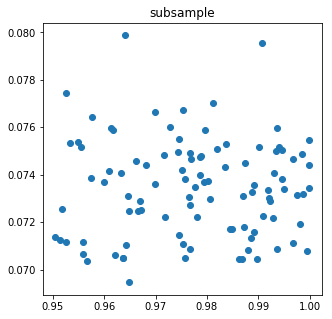

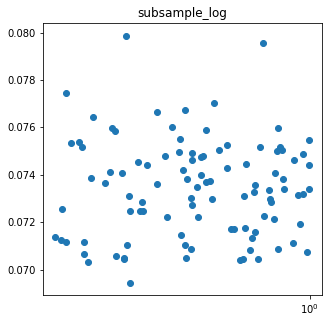

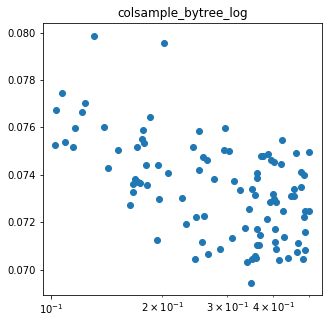

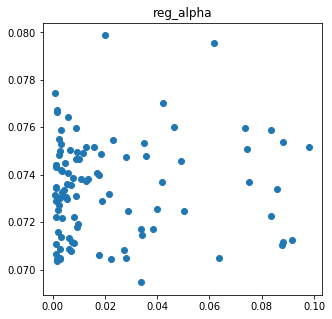

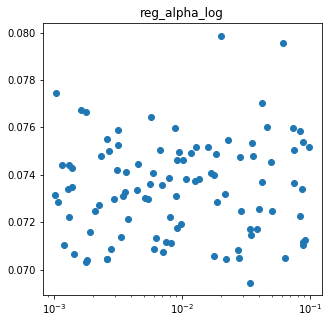

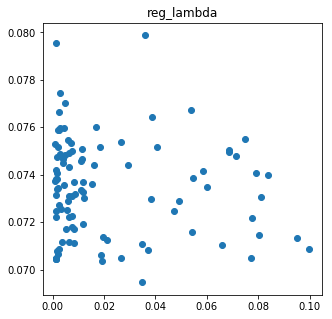

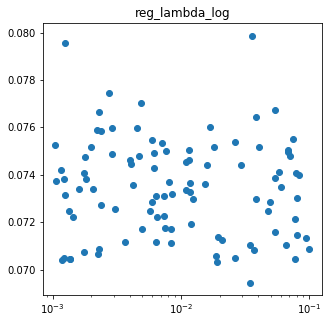

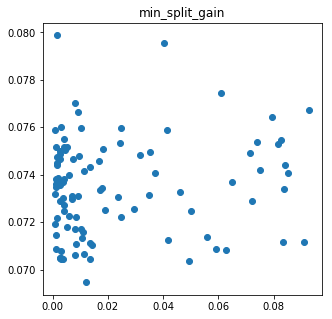

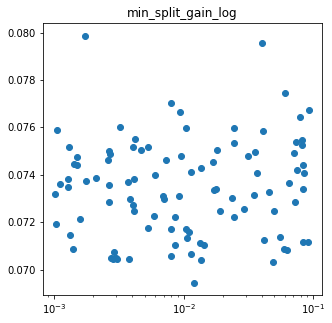

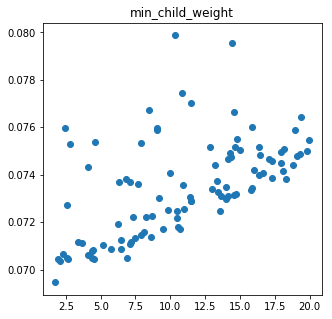

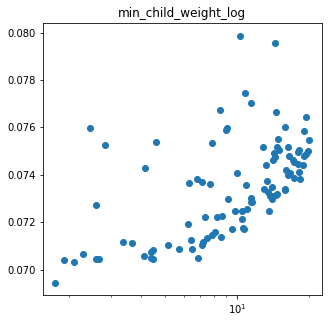

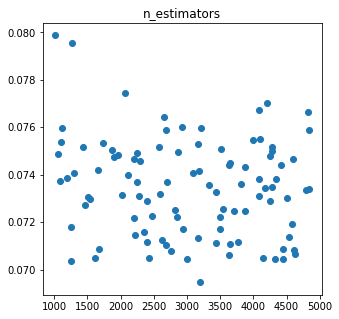

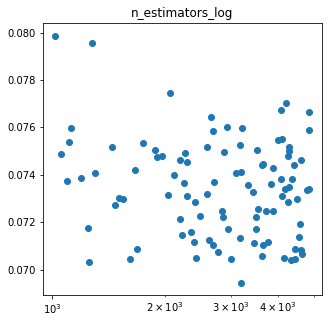

In [157]:
param_samplers = {
    'learning_rate': LogUniformSampler(-2, -1),
    'subsample': UniformSampler(0.95, 1),
    'colsample_bytree': UniformSampler(0.1, 0.5),
    'reg_alpha': LogUniformSampler(-3, -1),
    'reg_lambda': LogUniformSampler(-3, -1),
    'min_split_gain': LogUniformSampler(-3, -1),
    'min_child_weight': UniformSampler(1, 20),
    'n_estimators': UniformSampler(1000, 5000, int),
    'max_depth': UniformSampler(2, 3, int)
}
 
folds = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)
param_list = []
score_list = []
n_seed = 100
for i_seed in range(n_seed):
    print(i_seed, time.ctime())
    gal_clfs = []
    gal_importances = pd.DataFrame()
    gal_lgb_params = {
        'boosting_type': 'gbdt',
        'objective': 'multiclass',
        'num_class': 5,
        'metric': 'multi_logloss',
        'class_weight': gal_class_weight,
        'learning_rate': param_samplers['learning_rate'].rvs(),
        'subsample': param_samplers['subsample'].rvs(),
        'colsample_bytree': param_samplers['colsample_bytree'].rvs(),
        'reg_alpha': param_samplers['reg_alpha'].rvs(),
        'reg_lambda': param_samplers['reg_lambda'].rvs(),
        'min_split_gain': param_samplers['min_split_gain'].rvs(),
        'min_child_weight': param_samplers['min_child_weight'].rvs(),
        'n_estimators': param_samplers['n_estimators'].rvs(),
        'max_depth': param_samplers['max_depth'].rvs(),
        'silent': True,
        'n_jobs': 6
    }
    
    param_list.append(gal_lgb_params)
    
    seed_score_list = []
    for i_fold, (trn_index, val_index) in enumerate(folds.split(gal_target_i, gal_target_i)):
        trn_x, trn_y = gal_df.iloc[trn_index], gal_target_i.iloc[trn_index]
        val_x, val_y = gal_df.iloc[val_index], gal_target_i.iloc[val_index]

        gal_clf = lgb.LGBMClassifier(**gal_lgb_params)
        gal_clf.fit(
            trn_x, trn_y,
            sample_weight=trn_y.map(gal_sample_weights),
            eval_set=[(val_x, val_y)],
            eval_metric='multi_logloss',
            eval_class_weight=[gal_class_weight],
            verbose=False,
            early_stopping_rounds=50
        )

        imp_df = pd.DataFrame()
        imp_df['feature'] = gal_df.columns
        imp_df['gain'] = gal_clf.feature_importances_
        imp_df['fold'] = i_fold + 1
        gal_importances = pd.concat([gal_importances, imp_df], axis=0, sort=False)

        gal_clfs.append(gal_clf)
        
        seed_score_list.append(gal_clf.best_score_['valid_0']['multi_logloss'])
    score_list.append(np.mean(seed_score_list))


param_keys = ['learning_rate',
  'subsample',
  'colsample_bytree',
  'reg_alpha',
  'reg_lambda',
  'min_split_gain',
  'min_child_weight',
  'n_estimators',
  'max_depth']

for param_key in param_keys:
    values = [ param_dict[param_key] for param_dict in param_list]
    plt.figure(figsize=(5, 5))
    plt.title(param_key)
    plt.plot(values, score_list, 'o')
    plt.figure(figsize=(5, 5))
    plt.title(param_key+'_log')
    plt.plot(values, score_list, 'o')
    plt.xscale('log')

0 Fri Dec  7 23:21:27 2018
1 Fri Dec  7 23:21:28 2018
2 Fri Dec  7 23:21:30 2018
3 Fri Dec  7 23:21:31 2018
4 Fri Dec  7 23:21:33 2018
5 Fri Dec  7 23:21:34 2018
6 Fri Dec  7 23:21:35 2018
7 Fri Dec  7 23:21:37 2018
8 Fri Dec  7 23:21:38 2018
9 Fri Dec  7 23:21:40 2018
10 Fri Dec  7 23:21:42 2018
11 Fri Dec  7 23:21:43 2018
12 Fri Dec  7 23:21:45 2018
13 Fri Dec  7 23:21:47 2018
14 Fri Dec  7 23:21:49 2018
15 Fri Dec  7 23:21:50 2018
16 Fri Dec  7 23:21:51 2018
17 Fri Dec  7 23:21:53 2018
18 Fri Dec  7 23:21:55 2018
19 Fri Dec  7 23:21:57 2018
20 Fri Dec  7 23:21:58 2018
21 Fri Dec  7 23:22:00 2018
22 Fri Dec  7 23:22:01 2018
23 Fri Dec  7 23:22:03 2018
24 Fri Dec  7 23:22:04 2018
25 Fri Dec  7 23:22:06 2018
26 Fri Dec  7 23:22:08 2018
27 Fri Dec  7 23:22:10 2018
28 Fri Dec  7 23:22:12 2018
29 Fri Dec  7 23:22:13 2018
30 Fri Dec  7 23:22:15 2018
31 Fri Dec  7 23:22:17 2018
32 Fri Dec  7 23:22:18 2018
33 Fri Dec  7 23:22:20 2018
34 Fri Dec  7 23:22:21 2018
35 Fri Dec  7 23:22:23 2018
36

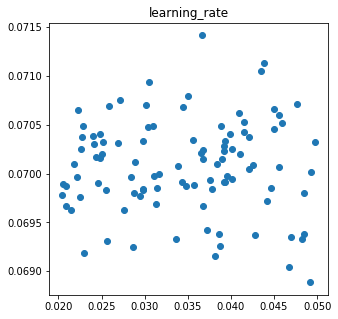

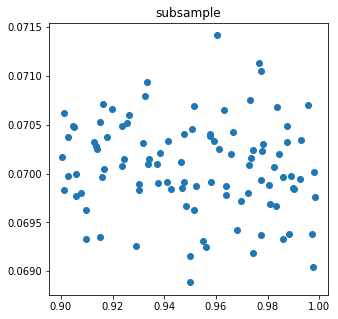

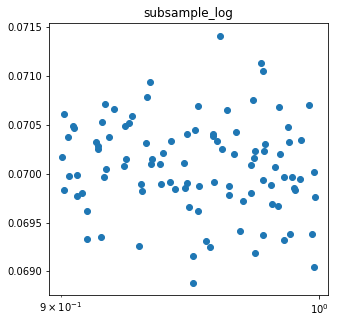

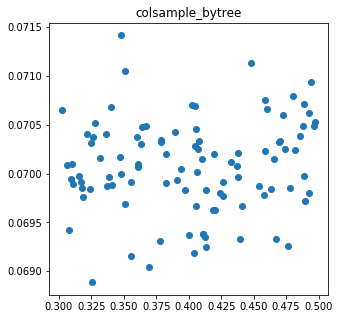

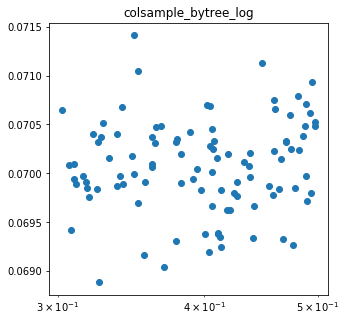

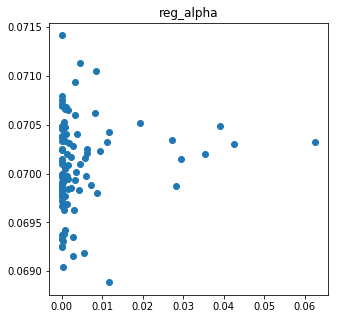

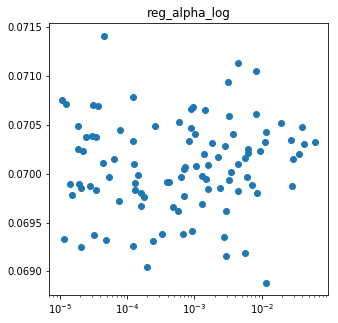

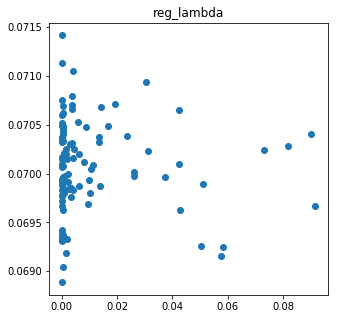

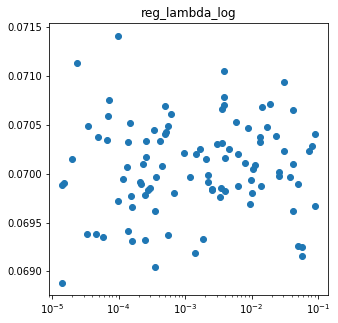

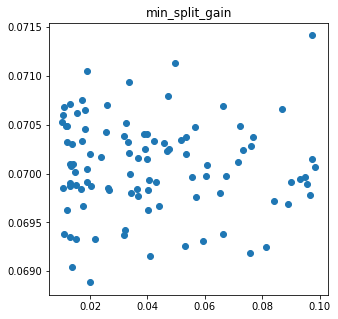

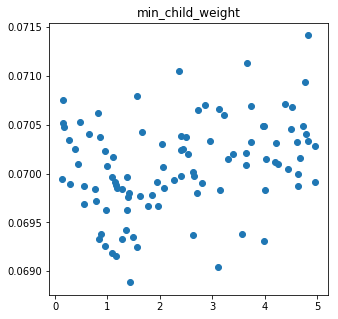

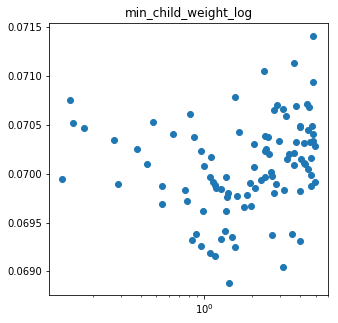

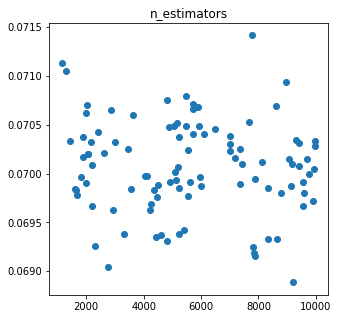

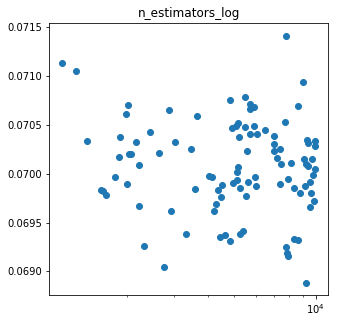

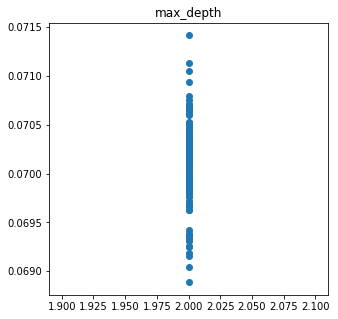

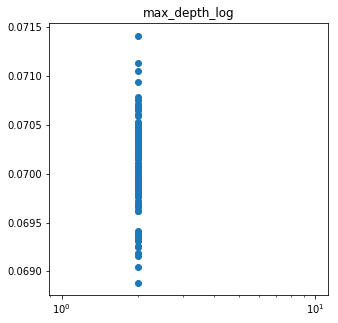

In [158]:
param_samplers = {
    'learning_rate': UniformSampler(0.02, 0.05),
    'subsample': UniformSampler(0.9, 1),
    'colsample_bytree': UniformSampler(0.3, 0.5),
    'reg_alpha': LogUniformSampler(-5, -1),
    'reg_lambda': LogUniformSampler(-5, -1),
    'min_split_gain': LogUniformSampler(-2, -1),
    'min_child_weight': UniformSampler(0.1, 5),
    'n_estimators': UniformSampler(1000, 10000, int),
    'max_depth': UniformSampler(2, 3, int)
}
 
folds = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)
param_list = []
score_list = []
n_seed = 100
for i_seed in range(n_seed):
    print(i_seed, time.ctime())
    gal_clfs = []
    gal_importances = pd.DataFrame()
    gal_lgb_params = {
        'boosting_type': 'gbdt',
        'objective': 'multiclass',
        'num_class': 5,
        'metric': 'multi_logloss',
        'class_weight': gal_class_weight,
        'learning_rate': param_samplers['learning_rate'].rvs(),
        'subsample': param_samplers['subsample'].rvs(),
        'colsample_bytree': param_samplers['colsample_bytree'].rvs(),
        'reg_alpha': param_samplers['reg_alpha'].rvs(),
        'reg_lambda': param_samplers['reg_lambda'].rvs(),
        'min_split_gain': param_samplers['min_split_gain'].rvs(),
        'min_child_weight': param_samplers['min_child_weight'].rvs(),
        'n_estimators': param_samplers['n_estimators'].rvs(),
        'max_depth': param_samplers['max_depth'].rvs(),
        'silent': True,
        'n_jobs': 6
    }
    
    param_list.append(gal_lgb_params)
    
    seed_score_list = []
    for i_fold, (trn_index, val_index) in enumerate(folds.split(gal_target_i, gal_target_i)):
        trn_x, trn_y = gal_df.iloc[trn_index], gal_target_i.iloc[trn_index]
        val_x, val_y = gal_df.iloc[val_index], gal_target_i.iloc[val_index]

        gal_clf = lgb.LGBMClassifier(**gal_lgb_params)
        gal_clf.fit(
            trn_x, trn_y,
            sample_weight=trn_y.map(gal_sample_weights),
            eval_set=[(val_x, val_y)],
            eval_metric='multi_logloss',
            eval_class_weight=[gal_class_weight],
            verbose=False,
            early_stopping_rounds=50
        )

        imp_df = pd.DataFrame()
        imp_df['feature'] = gal_df.columns
        imp_df['gain'] = gal_clf.feature_importances_
        imp_df['fold'] = i_fold + 1
        gal_importances = pd.concat([gal_importances, imp_df], axis=0, sort=False)

        gal_clfs.append(gal_clf)
        
        seed_score_list.append(gal_clf.best_score_['valid_0']['multi_logloss'])
    score_list.append(np.mean(seed_score_list))


param_keys = ['learning_rate',
  'subsample',
  'colsample_bytree',
  'reg_alpha',
  'reg_lambda',
  'min_split_gain',
  'min_child_weight',
  'n_estimators',
  'max_depth']

for param_key in param_keys:
    values = [ param_dict[param_key] for param_dict in param_list]
    plt.figure(figsize=(5, 5))
    plt.title(param_key)
    plt.plot(values, score_list, 'o')
    plt.figure(figsize=(5, 5))
    plt.title(param_key+'_log')
    plt.plot(values, score_list, 'o')
    plt.xscale('log')

0 Fri Dec  7 23:29:37 2018
1 Fri Dec  7 23:29:38 2018
2 Fri Dec  7 23:29:40 2018
3 Fri Dec  7 23:29:41 2018
4 Fri Dec  7 23:29:43 2018
5 Fri Dec  7 23:29:46 2018
6 Fri Dec  7 23:29:48 2018
7 Fri Dec  7 23:29:49 2018
8 Fri Dec  7 23:29:50 2018
9 Fri Dec  7 23:29:52 2018
10 Fri Dec  7 23:29:54 2018
11 Fri Dec  7 23:29:56 2018
12 Fri Dec  7 23:29:57 2018
13 Fri Dec  7 23:30:00 2018
14 Fri Dec  7 23:30:03 2018
15 Fri Dec  7 23:30:05 2018
16 Fri Dec  7 23:30:07 2018
17 Fri Dec  7 23:30:08 2018
18 Fri Dec  7 23:30:11 2018
19 Fri Dec  7 23:30:14 2018
20 Fri Dec  7 23:30:16 2018
21 Fri Dec  7 23:30:18 2018
22 Fri Dec  7 23:30:19 2018
23 Fri Dec  7 23:30:21 2018
24 Fri Dec  7 23:30:23 2018
25 Fri Dec  7 23:30:24 2018
26 Fri Dec  7 23:30:25 2018
27 Fri Dec  7 23:30:27 2018
28 Fri Dec  7 23:30:30 2018
29 Fri Dec  7 23:30:31 2018
30 Fri Dec  7 23:30:33 2018
31 Fri Dec  7 23:30:35 2018
32 Fri Dec  7 23:30:37 2018
33 Fri Dec  7 23:30:39 2018
34 Fri Dec  7 23:30:41 2018
35 Fri Dec  7 23:30:43 2018
36

KeyError: 'reg_lambda'

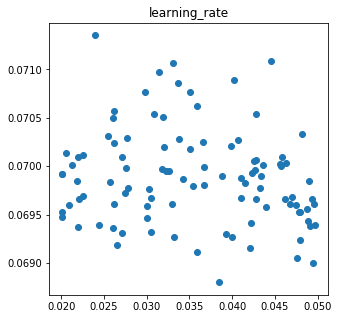

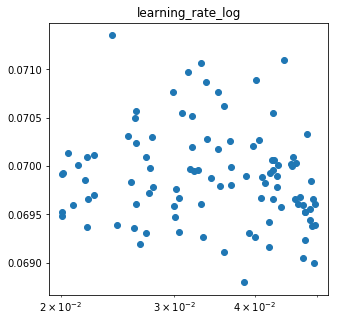

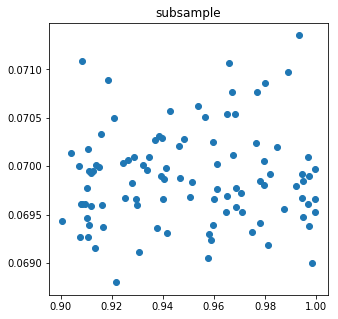

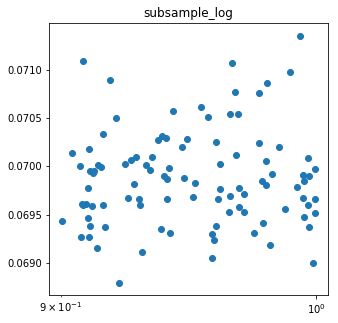

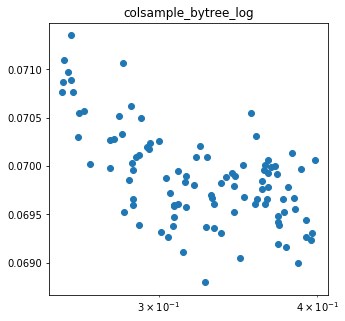

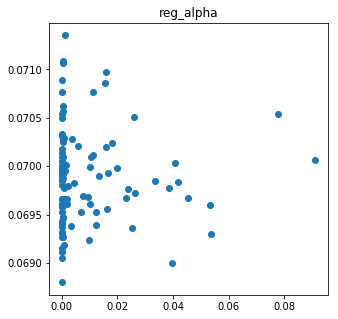

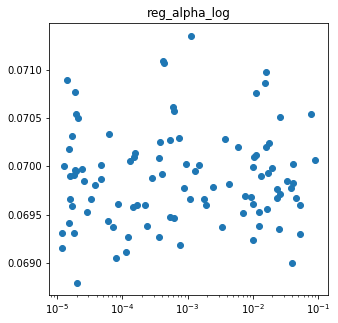

In [160]:
param_samplers = {
    'learning_rate': UniformSampler(0.02, 0.05),
    'subsample': UniformSampler(0.9, 1),
    'colsample_bytree': UniformSampler(0.25, 0.4),
    'reg_alpha': LogUniformSampler(-5, -1),
    'min_split_gain': LogUniformSampler(-2, -1),
    'min_child_weight': UniformSampler(0.8, 2),
    'n_estimators': UniformSampler(2000, 10000, int),
    'max_depth': UniformSampler(2, 3, int)
}
 
folds = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)
param_list = []
score_list = []
n_seed = 100
for i_seed in range(n_seed):
    print(i_seed, time.ctime())
    gal_clfs = []
    gal_importances = pd.DataFrame()
    gal_lgb_params = {
        'boosting_type': 'gbdt',
        'objective': 'multiclass',
        'num_class': 5,
        'metric': 'multi_logloss',
        'class_weight': gal_class_weight,
        'learning_rate': param_samplers['learning_rate'].rvs(),
        'subsample': param_samplers['subsample'].rvs(),
        'colsample_bytree': param_samplers['colsample_bytree'].rvs(),
        'reg_alpha': param_samplers['reg_alpha'].rvs(),
        'min_split_gain': param_samplers['min_split_gain'].rvs(),
        'min_child_weight': param_samplers['min_child_weight'].rvs(),
        'n_estimators': param_samplers['n_estimators'].rvs(),
        'max_depth': param_samplers['max_depth'].rvs(),
        'silent': True,
        'n_jobs': 6
    }
    
    param_list.append(gal_lgb_params)
    
    seed_score_list = []
    for i_fold, (trn_index, val_index) in enumerate(folds.split(gal_target_i, gal_target_i)):
        trn_x, trn_y = gal_df.iloc[trn_index], gal_target_i.iloc[trn_index]
        val_x, val_y = gal_df.iloc[val_index], gal_target_i.iloc[val_index]

        gal_clf = lgb.LGBMClassifier(**gal_lgb_params)
        gal_clf.fit(
            trn_x, trn_y,
            sample_weight=trn_y.map(gal_sample_weights),
            eval_set=[(val_x, val_y)],
            eval_metric='multi_logloss',
            eval_class_weight=[gal_class_weight],
            verbose=False,
            early_stopping_rounds=50
        )

        imp_df = pd.DataFrame()
        imp_df['feature'] = gal_df.columns
        imp_df['gain'] = gal_clf.feature_importances_
        imp_df['fold'] = i_fold + 1
        gal_importances = pd.concat([gal_importances, imp_df], axis=0, sort=False)

        gal_clfs.append(gal_clf)
        
        seed_score_list.append(gal_clf.best_score_['valid_0']['multi_logloss'])
    score_list.append(np.mean(seed_score_list))


param_keys = ['learning_rate',
  'subsample',
  'colsample_bytree',
  'reg_alpha',

  'min_split_gain',
  'min_child_weight',
  'n_estimators',
  'max_depth']

for param_key in param_keys:
    values = [ param_dict[param_key] for param_dict in param_list]
    plt.figure(figsize=(5, 5))
    plt.title(param_key)
    plt.plot(values, score_list, 'o')
    plt.figure(figsize=(5, 5))
    plt.title(param_key+'_log')
    plt.plot(values, score_list, 'o')
    plt.xscale('log')

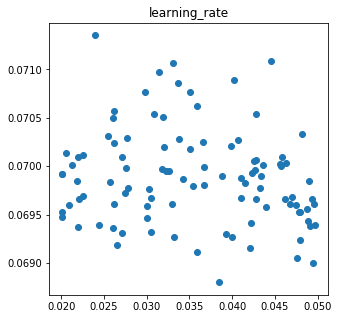

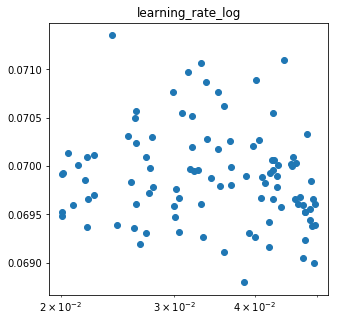

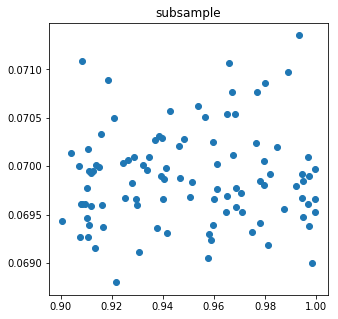

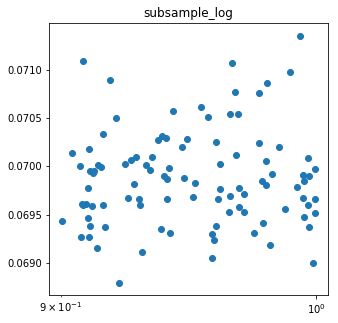

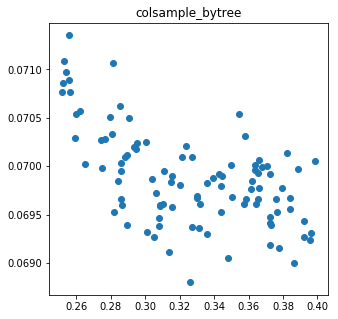

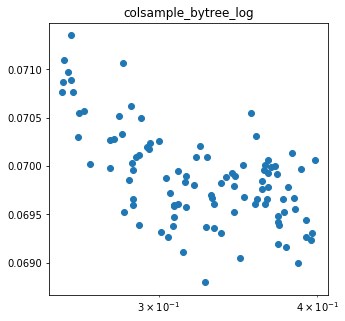

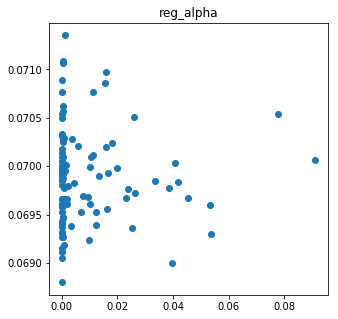

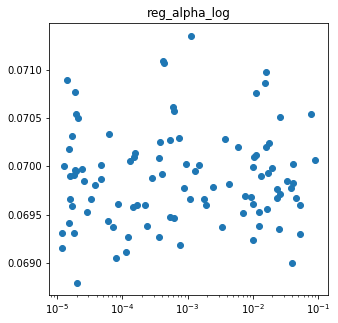

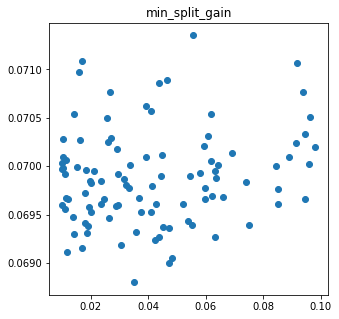

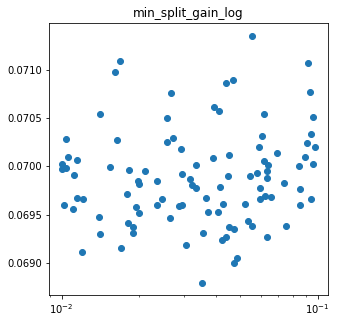

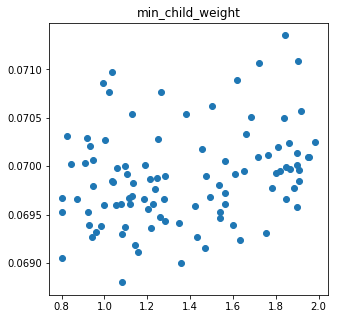

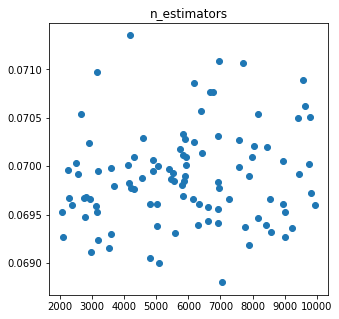

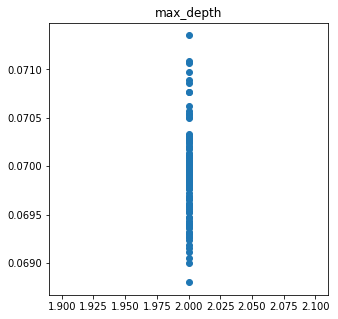

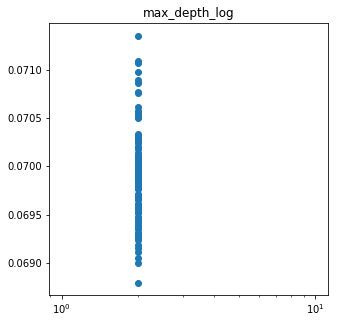

In [161]:
param_keys = ['learning_rate',
  'subsample',
  'colsample_bytree',
  'reg_alpha',
  'min_split_gain',
  'min_child_weight',
  'n_estimators',
  'max_depth']

for param_key in param_keys:
    values = [ param_dict[param_key] for param_dict in param_list]
    plt.figure(figsize=(5, 5))
    plt.title(param_key)
    plt.plot(values, score_list, 'o')
    plt.figure(figsize=(5, 5))
    plt.title(param_key+'_log')
    plt.plot(values, score_list, 'o')
    plt.xscale('log')

0 Fri Dec  7 23:43:11 2018
1 Fri Dec  7 23:43:13 2018
2 Fri Dec  7 23:43:15 2018
3 Fri Dec  7 23:43:16 2018
4 Fri Dec  7 23:43:18 2018
5 Fri Dec  7 23:43:20 2018
6 Fri Dec  7 23:43:21 2018
7 Fri Dec  7 23:43:23 2018
8 Fri Dec  7 23:43:24 2018
9 Fri Dec  7 23:43:26 2018
10 Fri Dec  7 23:43:27 2018
11 Fri Dec  7 23:43:29 2018
12 Fri Dec  7 23:43:31 2018
13 Fri Dec  7 23:43:32 2018
14 Fri Dec  7 23:43:33 2018
15 Fri Dec  7 23:43:35 2018
16 Fri Dec  7 23:43:36 2018
17 Fri Dec  7 23:43:38 2018
18 Fri Dec  7 23:43:39 2018
19 Fri Dec  7 23:43:41 2018
20 Fri Dec  7 23:43:42 2018
21 Fri Dec  7 23:43:44 2018
22 Fri Dec  7 23:43:45 2018
23 Fri Dec  7 23:43:47 2018
24 Fri Dec  7 23:43:48 2018
25 Fri Dec  7 23:43:50 2018
26 Fri Dec  7 23:43:51 2018
27 Fri Dec  7 23:43:53 2018
28 Fri Dec  7 23:43:54 2018
29 Fri Dec  7 23:43:56 2018
30 Fri Dec  7 23:43:57 2018
31 Fri Dec  7 23:43:58 2018
32 Fri Dec  7 23:44:00 2018
33 Fri Dec  7 23:44:01 2018
34 Fri Dec  7 23:44:02 2018
35 Fri Dec  7 23:44:04 2018
36

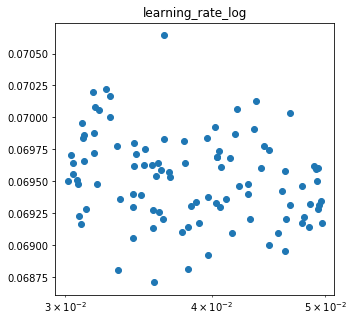

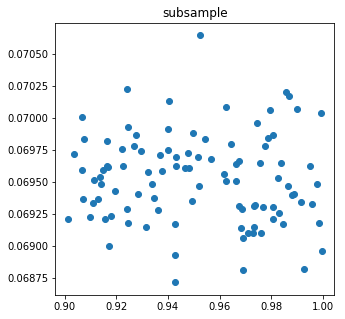

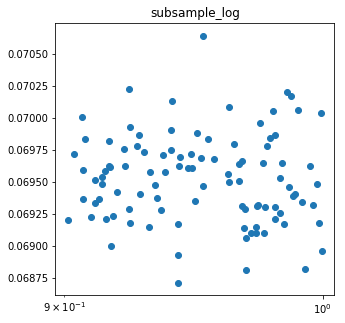

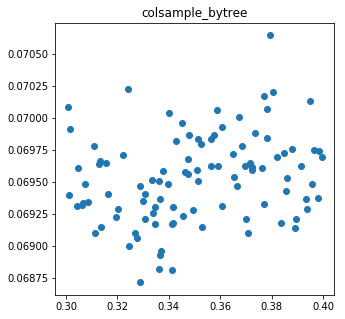

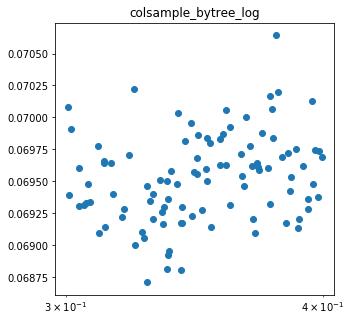

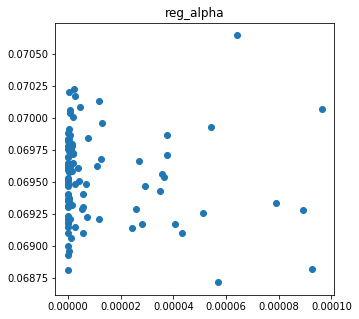

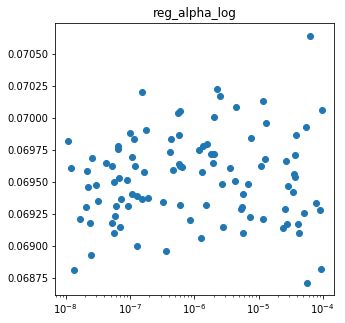

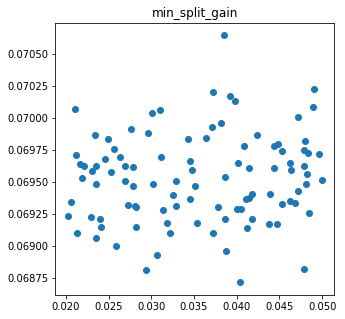

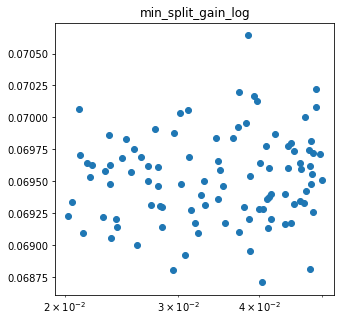

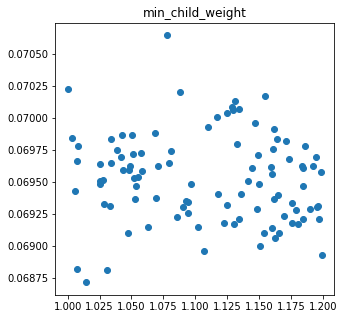

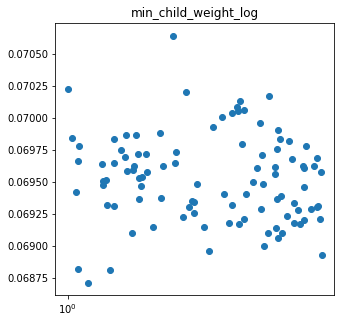

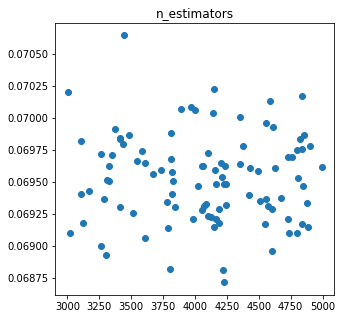

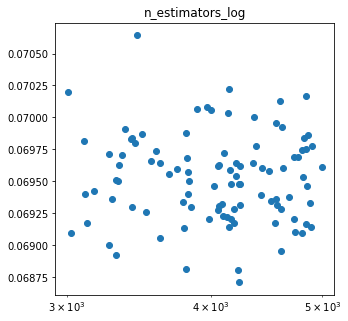

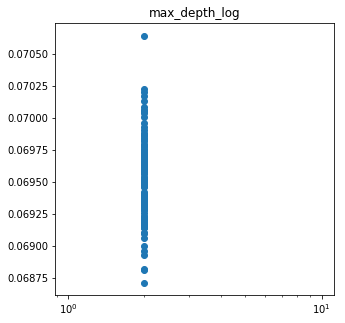

In [162]:
param_samplers = {
    'learning_rate': UniformSampler(0.03, 0.05),
    'subsample': UniformSampler(0.9, 1),
    'colsample_bytree': UniformSampler(0.3, 0.4),
    'reg_alpha': LogUniformSampler(-8, -4),
    'min_split_gain': UniformSampler(0.02, 0.05),
    'min_child_weight': UniformSampler(1, 1.2),
    'n_estimators': UniformSampler(3000, 5000, int),
    'max_depth': UniformSampler(2, 3, int)
}
 
folds = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)
param_list = []
score_list = []
n_seed = 100
for i_seed in range(n_seed):
    print(i_seed, time.ctime())
    gal_clfs = []
    gal_importances = pd.DataFrame()
    gal_lgb_params = {
        'boosting_type': 'gbdt',
        'objective': 'multiclass',
        'num_class': 5,
        'metric': 'multi_logloss',
        'class_weight': gal_class_weight,
        'learning_rate': param_samplers['learning_rate'].rvs(),
        'subsample': param_samplers['subsample'].rvs(),
        'colsample_bytree': param_samplers['colsample_bytree'].rvs(),
        'reg_alpha': param_samplers['reg_alpha'].rvs(),
        'min_split_gain': param_samplers['min_split_gain'].rvs(),
        'min_child_weight': param_samplers['min_child_weight'].rvs(),
        'n_estimators': param_samplers['n_estimators'].rvs(),
        'max_depth': param_samplers['max_depth'].rvs(),
        'silent': True,
        'n_jobs': 6
    }
    
    param_list.append(gal_lgb_params)
    
    seed_score_list = []
    for i_fold, (trn_index, val_index) in enumerate(folds.split(gal_target_i, gal_target_i)):
        trn_x, trn_y = gal_df.iloc[trn_index], gal_target_i.iloc[trn_index]
        val_x, val_y = gal_df.iloc[val_index], gal_target_i.iloc[val_index]

        gal_clf = lgb.LGBMClassifier(**gal_lgb_params)
        gal_clf.fit(
            trn_x, trn_y,
            sample_weight=trn_y.map(gal_sample_weights),
            eval_set=[(val_x, val_y)],
            eval_metric='multi_logloss',
            eval_class_weight=[gal_class_weight],
            verbose=False,
            early_stopping_rounds=50
        )

        imp_df = pd.DataFrame()
        imp_df['feature'] = gal_df.columns
        imp_df['gain'] = gal_clf.feature_importances_
        imp_df['fold'] = i_fold + 1
        gal_importances = pd.concat([gal_importances, imp_df], axis=0, sort=False)

        gal_clfs.append(gal_clf)
        
        seed_score_list.append(gal_clf.best_score_['valid_0']['multi_logloss'])
    score_list.append(np.mean(seed_score_list))


param_keys = ['learning_rate',
  'subsample',
  'colsample_bytree',
  'reg_alpha',
  'min_split_gain',
  'min_child_weight',
  'n_estimators',
  'max_depth']

for param_key in param_keys:
    values = [ param_dict[param_key] for param_dict in param_list]
    plt.figure(figsize=(5, 5))
    plt.title(param_key)
    plt.plot(values, score_list, 'o')
    plt.figure(figsize=(5, 5))
    plt.title(param_key+'_log')
    plt.plot(values, score_list, 'o')
    plt.xscale('log')

0 Sat Dec  8 00:20:42 2018
1 Sat Dec  8 00:20:43 2018
2 Sat Dec  8 00:20:45 2018
3 Sat Dec  8 00:20:46 2018
4 Sat Dec  8 00:20:48 2018
5 Sat Dec  8 00:20:49 2018
6 Sat Dec  8 00:20:51 2018
7 Sat Dec  8 00:20:53 2018
8 Sat Dec  8 00:20:54 2018
9 Sat Dec  8 00:20:56 2018
10 Sat Dec  8 00:20:57 2018
11 Sat Dec  8 00:20:59 2018
12 Sat Dec  8 00:21:00 2018
13 Sat Dec  8 00:21:02 2018
14 Sat Dec  8 00:21:04 2018
15 Sat Dec  8 00:21:06 2018
16 Sat Dec  8 00:21:08 2018
17 Sat Dec  8 00:21:10 2018
18 Sat Dec  8 00:21:12 2018
19 Sat Dec  8 00:21:13 2018
20 Sat Dec  8 00:21:15 2018
21 Sat Dec  8 00:21:17 2018
22 Sat Dec  8 00:21:19 2018
23 Sat Dec  8 00:21:20 2018
24 Sat Dec  8 00:21:22 2018
25 Sat Dec  8 00:21:24 2018
26 Sat Dec  8 00:21:25 2018
27 Sat Dec  8 00:21:27 2018
28 Sat Dec  8 00:21:28 2018
29 Sat Dec  8 00:21:30 2018
30 Sat Dec  8 00:21:31 2018
31 Sat Dec  8 00:21:33 2018
32 Sat Dec  8 00:21:35 2018
33 Sat Dec  8 00:21:36 2018
34 Sat Dec  8 00:21:38 2018
35 Sat Dec  8 00:21:39 2018
36

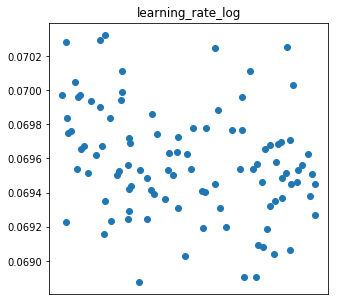

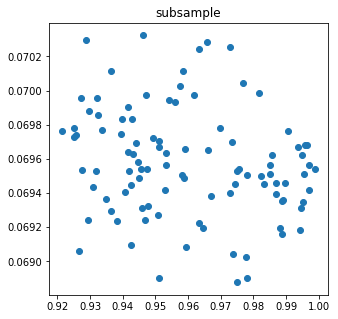

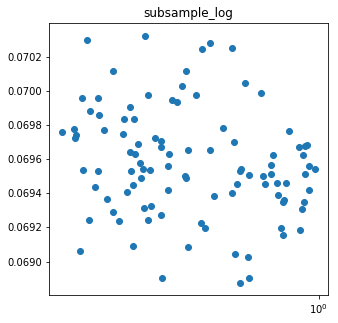

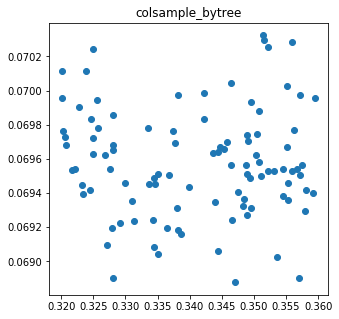

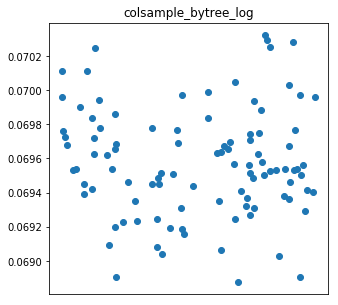

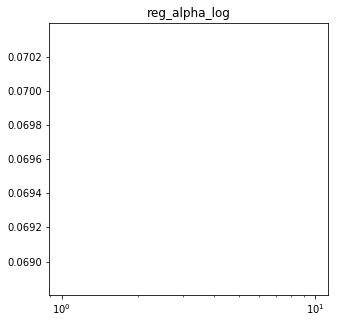

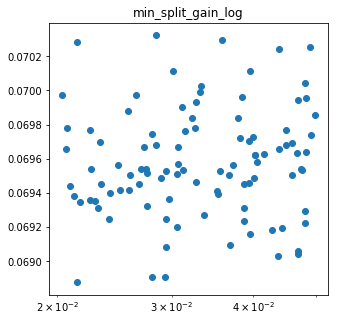

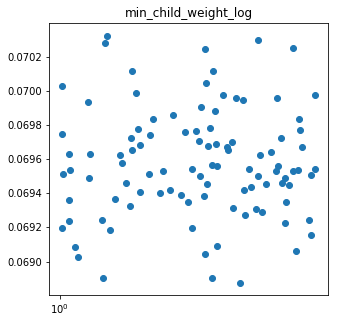

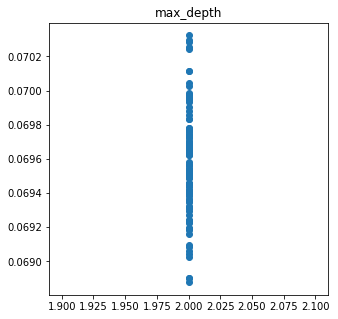

In [165]:
param_samplers = {
    'learning_rate': UniformSampler(0.032, 0.038),
    'subsample': UniformSampler(0.92, 1),
    'colsample_bytree': UniformSampler(0.32, 0.36),
    'reg_alpha': UniformSampler(0, 1, int),
    'min_split_gain': UniformSampler(0.02, 0.05),
    'min_child_weight': UniformSampler(1, 1.1),
    'n_estimators': UniformSampler(3000, 5000, int),
    'max_depth': UniformSampler(2, 3, int)
}
 
folds = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)
param_list = []
score_list = []
n_seed = 100
for i_seed in range(n_seed):
    print(i_seed, time.ctime())
    gal_clfs = []
    gal_importances = pd.DataFrame()
    gal_lgb_params = {
        'boosting_type': 'gbdt',
        'objective': 'multiclass',
        'num_class': 5,
        'metric': 'multi_logloss',
        'class_weight': gal_class_weight,
        'learning_rate': param_samplers['learning_rate'].rvs(),
        'subsample': param_samplers['subsample'].rvs(),
        'colsample_bytree': param_samplers['colsample_bytree'].rvs(),
        'reg_alpha': param_samplers['reg_alpha'].rvs(),
        'min_split_gain': param_samplers['min_split_gain'].rvs(),
        'min_child_weight': param_samplers['min_child_weight'].rvs(),
        'n_estimators': param_samplers['n_estimators'].rvs(),
        'max_depth': param_samplers['max_depth'].rvs(),
        'silent': True,
        'n_jobs': -1
    }
    
    param_list.append(gal_lgb_params)
    
    seed_score_list = []
    for i_fold, (trn_index, val_index) in enumerate(folds.split(gal_target_i, gal_target_i)):
        trn_x, trn_y = gal_df.iloc[trn_index], gal_target_i.iloc[trn_index]
        val_x, val_y = gal_df.iloc[val_index], gal_target_i.iloc[val_index]

        gal_clf = lgb.LGBMClassifier(**gal_lgb_params)
        gal_clf.fit(
            trn_x, trn_y,
            sample_weight=trn_y.map(gal_sample_weights),
            eval_set=[(val_x, val_y)],
            eval_metric='multi_logloss',
            eval_class_weight=[gal_class_weight],
            verbose=False,
            early_stopping_rounds=50
        )

        imp_df = pd.DataFrame()
        imp_df['feature'] = gal_df.columns
        imp_df['gain'] = gal_clf.feature_importances_
        imp_df['fold'] = i_fold + 1
        gal_importances = pd.concat([gal_importances, imp_df], axis=0, sort=False)

        gal_clfs.append(gal_clf)
        
        seed_score_list.append(gal_clf.best_score_['valid_0']['multi_logloss'])
    score_list.append(np.mean(seed_score_list))


param_keys = ['learning_rate',
  'subsample',
  'colsample_bytree',
  'reg_alpha',
  'min_split_gain',
  'min_child_weight',
  'n_estimators',
  'max_depth']

for param_key in param_keys:
    values = [ param_dict[param_key] for param_dict in param_list]
    plt.figure(figsize=(5, 5))
    plt.title(param_key)
    plt.plot(values, score_list, 'o')
    plt.figure(figsize=(5, 5))
    plt.title(param_key+'_log')
    plt.plot(values, score_list, 'o')
    plt.xscale('log')